In [165]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

In [166]:
cols = [#'bayesian_prediction_std_bal_acc',
        #'bayesian_prediction_std_f1_score', 
        #'bayesian_prediction_std_auc',
        'epochs',
        'bayesian_entropy__bal_acc', 
        #'bayesian_entropy_f1_score',
        'bayesian_entropy__auc']

In [167]:
#experiments = ['bayesian', 'mlp_dropout', 'mlp_deterministic', 'poor_bayesian']
experiments = ['mlp_dropout', 'mlp_deterministic', 'poor_bayesian']

In [168]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_uncertainty_with_unknown.csv')
    df_with_results = df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_uncertainty_without_unknown.csv')
    df_without_results = df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [169]:
results_cols = ['inside', 'outside',
                'in_epochs', 'out_epochs',
                'in_entropy_acc', 'out_entropy_acc',
                'in_entropy_auc', 'out_entropy_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            in_key[0], in_key[1],
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
        ]
    dfs_results.append([exp, results])

In [170]:
final_results_cols = ['inside', 'outside']
for c in results_cols[2:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [171]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row  in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        assert prev_row[1] == row[1]
        
    _, *row = key_row[0]
    new_row = [row[0], row[1]]
    
    for c in range(2, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [172]:
final_results.columns

Index(['inside', 'outside', 'mlp_dropout_in_epochs',
       'mlp_deterministic_in_epochs', 'poor_bayesian_in_epochs',
       'mlp_dropout_out_epochs', 'mlp_deterministic_out_epochs',
       'poor_bayesian_out_epochs', 'mlp_dropout_in_entropy_acc',
       'mlp_deterministic_in_entropy_acc', 'poor_bayesian_in_entropy_acc',
       'mlp_dropout_out_entropy_acc', 'mlp_deterministic_out_entropy_acc',
       'poor_bayesian_out_entropy_acc', 'mlp_dropout_in_entropy_auc',
       'mlp_deterministic_in_entropy_auc', 'poor_bayesian_in_entropy_auc',
       'mlp_dropout_out_entropy_auc', 'mlp_deterministic_out_entropy_auc',
       'poor_bayesian_out_entropy_auc'],
      dtype='object')

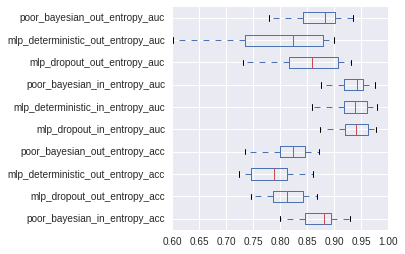

In [173]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 10)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[10:])
plt.subplots_adjust(left=0.4)

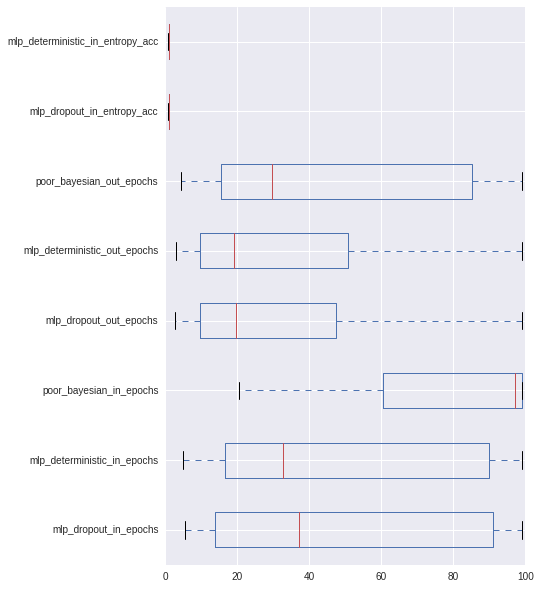

In [174]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 5)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[2:10])
plt.subplots_adjust(left=0.4)

In [176]:
code = '''
data {
    int K; // Number of groups
    int N; // Number of examples per group
    real y[N, K]; // Observations 
}
parameters {
    real mu; // Mean
    vector[K-1] theta_free; // Effects
    real<lower=0> sigma_likelihood; // Noise std
    real<lower=0> sigma_theta; // Effect std
}
transformed parameters {
  vector[K] theta; // Effects with sum to zero constraint

  for(k in 1:(K-1)) theta[k] <- theta_free[k];
  theta[K] <- -sum(theta_free);
}
model {
    sigma_theta ~ cauchy(0, 25);
    theta_free ~ normal(0, sigma_theta); // Weak effect prior

    mu ~ normal(0, 100); // Weak mean prior
    sigma_likelihood ~ uniform(0, 100); // Weak noise std prior
    
    for (i in 1:N)
        for (j in 1:K)
            y[i][j] ~ normal(mu + theta[j], sigma_likelihood); // Normal likelihood
}
'''

model = pystan.StanModel(model_code=code)

In [177]:
out_acc = ['mlp_deterministic_out_entropy_acc', 'mlp_dropout_out_entropy_acc', 'poor_bayesian_out_entropy_acc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['mlp_deterministic_in_entropy_acc', 'mlp_dropout_in_entropy_acc', 'poor_bayesian_in_entropy_acc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

In [196]:
y = y_in
(N, K) = y.shape

data = {'K': K, 'N': N, 'y': y}
fit = model.sampling(data=data, iter=1000, chains=4)

Inference for Stan model: anon_model_1eebbfb74357e7d3c2691d6ad3626e10.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.99  1.1e-3   0.05   1.89   1.96   1.99   2.02   2.09   2000   1.01
theta_free[0]    7.5e-3  1.0e-3   0.05  -0.09  -0.02 3.9e-3   0.03   0.11   2000    1.0
theta_free[1]   -9.5e-4  1.1e-3   0.05  -0.11  -0.02 4.8e-4   0.03    0.1   2000    1.0
sigma_likelihood   0.36  8.0e-4   0.04    0.3   0.34   0.36   0.39   0.44   2000   1.01
sigma_theta        0.33    0.05   2.18 6.6e-3   0.03   0.07   0.16    2.0   2000    1.0
theta[0]         7.5e-3  1.0e-3   0.05  -0.09  -0.02 3.9e-3   0.03   0.11   2000    1.0
theta[1]        -9.5e-4  1.1e-3   0.05  -0.11  -0.02 4.8e-4   0.03    0.1   2000    1.0
theta[2]        -6.6e-3  1.1e-3   0.05  -0.12  -0.04-4.2e-3   0.02   0.09   2000    1.0
lp__              32.

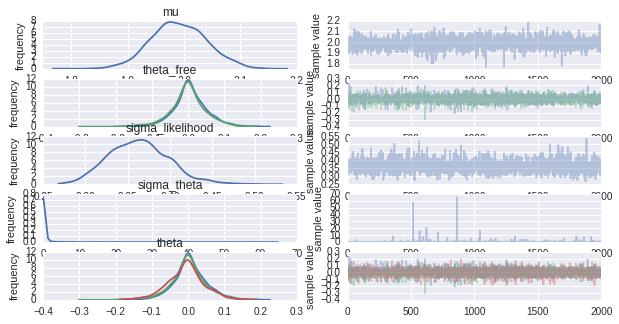

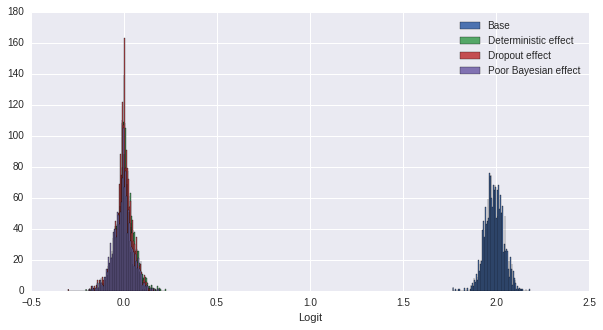

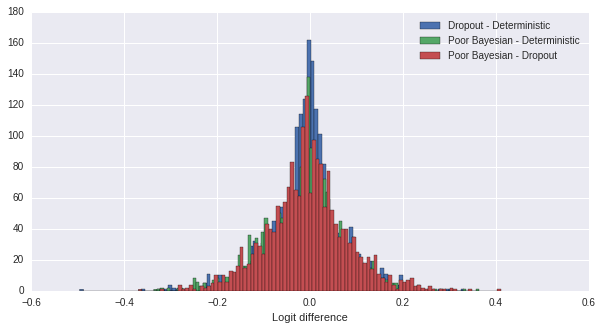

Dropout - Deterministic 95 CI: -0.192814188896 0.155784468677 Pr > 0: 0.4575
Poor Bayesian - Deterministic 95 CI: -0.199710315518 0.15450741761 Pr > 0: 0.4345
Poor Bayesian - Dropout 95 CI: -0.183126982093 0.181595194826 Pr > 0: 0.4615


In [197]:
print(fit)
fit.plot()
trace = fit.extract()

deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]

plt.figure()
plt.hist(trace['mu'], bins = 100, label = 'Base')
plt.hist(deterministic, bins = 100, label = 'Deterministic effect')
plt.hist(dropout, bins = 100, label = 'Dropout effect')
plt.hist(poor_bayesian, bins = 100, label = 'Poor Bayesian effect')
plt.legend()
plt.xlabel("Logit")
plt.show()

plt.figure()
plt.hist(dropout-deterministic, bins = 100, label = 'Dropout - Deterministic')
plt.hist(poor_bayesian-deterministic, bins = 100,label = 'Poor Bayesian - Deterministic')
plt.hist(poor_bayesian-dropout, bins = 100, label = 'Poor Bayesian - Dropout')
plt.legend()
plt.xlabel("Logit difference")
plt.show()

print('Dropout - Deterministic', '95 CI:', np.percentile(dropout-deterministic, 2.5), np.percentile(dropout-deterministic, 97.5), 'Pr > 0:', (dropout-deterministic > 0).mean())
print('Poor Bayesian - Deterministic', '95 CI:', np.percentile(poor_bayesian-deterministic, 2.5), np.percentile(poor_bayesian-deterministic, 97.5), 'Pr > 0:', (poor_bayesian-deterministic > 0).mean())
print('Poor Bayesian - Dropout', '95 CI:', np.percentile(poor_bayesian-dropout, 2.5), np.percentile(poor_bayesian-dropout, 97.5), 'Pr > 0:', (poor_bayesian-dropout > 0).mean())

In [188]:
y = y_out
(N, K) = y.shape

data = {'K': K, 'N': N, 'y': y}
fit = model.sampling(data=data, iter=1000, chains=4)

Inference for Stan model: anon_model_1eebbfb74357e7d3c2691d6ad3626e10.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.42  8.0e-4   0.04   1.35    1.4   1.42   1.45   1.49   2000    1.0
theta_free[0]     -0.14  1.3e-3   0.06  -0.25  -0.18  -0.14   -0.1  -0.02   2000    1.0
theta_free[1]      0.03  1.2e-3   0.05  -0.07 3.0e-4   0.03   0.07   0.14   2000    1.0
sigma_likelihood   0.29  6.1e-4   0.03   0.24   0.27   0.29   0.31   0.35   2000    1.0
sigma_theta        0.52    0.03   1.37   0.04   0.12   0.21   0.42   3.02   2000   1.01
theta[0]          -0.14  1.3e-3   0.06  -0.25  -0.18  -0.14   -0.1  -0.02   2000    1.0
theta[1]           0.03  1.2e-3   0.05  -0.07 3.0e-4   0.03   0.07   0.14   2000    1.0
theta[2]            0.1  1.2e-3   0.05 4.5e-3   0.07    0.1   0.14   0.21   2000    1.0
lp__              44.

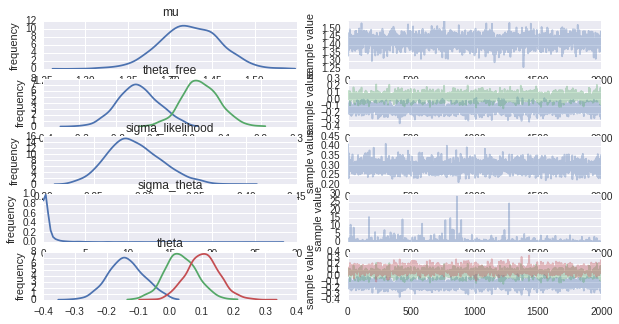

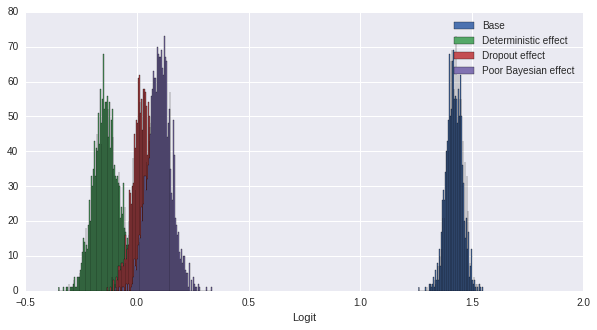

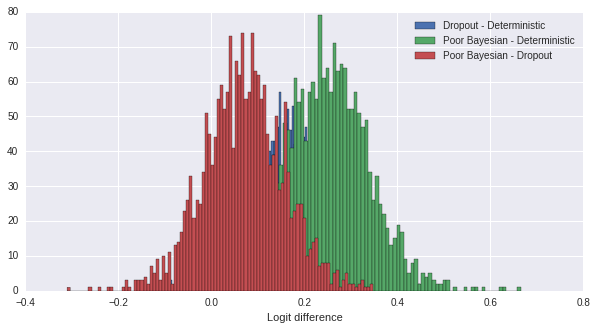

Dropout - Deterministic 95 CI: -0.0169721208247 0.355319103802 Pr > 0: 0.961
Poor Bayesian - Deterministic 95 CI: 0.0474599769113 0.431823291908 Pr > 0: 0.998
Poor Bayesian - Dropout 95 CI: -0.105902365859 0.244127678905 Pr > 0: 0.7935


In [195]:
print(fit)
fit.plot()
trace = fit.extract()

deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]

plt.figure()
plt.hist(trace['mu'], bins = 100, label = 'Base')
plt.hist(deterministic, bins = 100, label = 'Deterministic effect')
plt.hist(dropout, bins = 100, label = 'Dropout effect')
plt.hist(poor_bayesian, bins = 100, label = 'Poor Bayesian effect')
plt.legend()
plt.xlabel("Logit")
plt.show()

plt.figure()
plt.hist(dropout-deterministic, bins = 100, label = 'Dropout - Deterministic')
plt.hist(poor_bayesian-deterministic, bins = 100,label = 'Poor Bayesian - Deterministic')
plt.hist(poor_bayesian-dropout, bins = 100, label = 'Poor Bayesian - Dropout')
plt.legend()
plt.xlabel("Logit difference")
plt.show()

print('Dropout - Deterministic', '95 CI:', np.percentile(dropout-deterministic, 2.5), np.percentile(dropout-deterministic, 97.5), 'Pr > 0:', (dropout-deterministic > 0).mean())
print('Poor Bayesian - Deterministic', '95 CI:', np.percentile(poor_bayesian-deterministic, 2.5), np.percentile(poor_bayesian-deterministic, 97.5), 'Pr > 0:', (poor_bayesian-deterministic > 0).mean())
print('Poor Bayesian - Dropout', '95 CI:', np.percentile(poor_bayesian-dropout, 2.5), np.percentile(poor_bayesian-dropout, 97.5), 'Pr > 0:', (poor_bayesian-dropout > 0).mean())

In [209]:
code = '''
data {
    int K; // Number of groups
    int N; // Number of examples per group
    real y_in[N, K]; // Observations (inside only)
    real y_out[N, K]; // Observations (including outsiders)
}
parameters {
    real mu_in; // Mean (inside only)
    real mu_out; // Mean (including outsiders)
    vector[K-1] theta_free; // Effects
    real<lower=0> sigma_likelihood; // Noise std
    real<lower=0> sigma_theta; // Effect std
}
transformed parameters {
  vector[K] theta; // Effects with sum to zero constraint

  for(k in 1:(K-1)) theta[k] <- theta_free[k];
  theta[K] <- -sum(theta_free);
}
model {
    sigma_theta ~ cauchy(0, 25);
    theta_free ~ normal(0, sigma_theta); // Weak effect prior

    mu_in ~ normal(0, 100); // Weak mean prior
    mu_out ~ normal(0, 100); // Weak mean prior

    sigma_likelihood ~ uniform(0, 100); // Weak noise std prior (half-normal)
    
    for (i in 1:N)
        for (j in 1:K) {
            // Normal likelihood
            y_in[i][j] ~ normal(mu_in + theta[j], sigma_likelihood); 
            y_out[i][j] ~ normal(mu_out + theta[j], sigma_likelihood);
        }
}
'''

model_two_way = pystan.StanModel(model_code=code)

Inference for Stan model: anon_model_8ab7764af0212b6538e6ac6793ece96b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_in              1.99  8.8e-4   0.04   1.91   1.96   1.99   2.01   2.07   2000    1.0
mu_out             1.43  9.7e-4   0.04   1.34    1.4   1.42   1.46   1.51   2000   1.01
theta_free[0]     -0.05  9.1e-4   0.04  -0.13  -0.08  -0.04  -0.02   0.02   2000    1.0
theta_free[1]    9.4e-3  8.1e-4   0.04  -0.06  -0.01 5.0e-3   0.03   0.09   2000    1.0
sigma_likelihood   0.33  4.8e-4   0.02   0.29   0.31   0.33   0.34   0.38   2000    1.0
sigma_theta         0.3    0.03   1.33 8.8e-3   0.04   0.08   0.17   1.78   2000    1.0
theta[0]          -0.05  9.1e-4   0.04  -0.13  -0.08  -0.04  -0.02   0.02   2000    1.0
theta[1]         9.4e-3  8.1e-4   0.04  -0.06  -0.01 5.0e-3   0.03   0.09   2000    1.0
theta[2]           0.

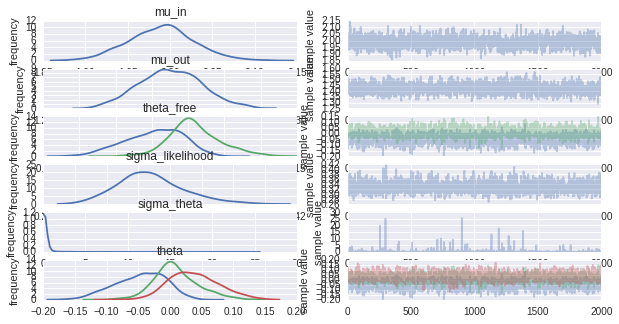

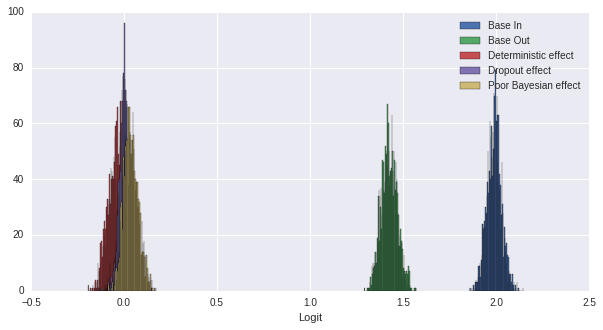

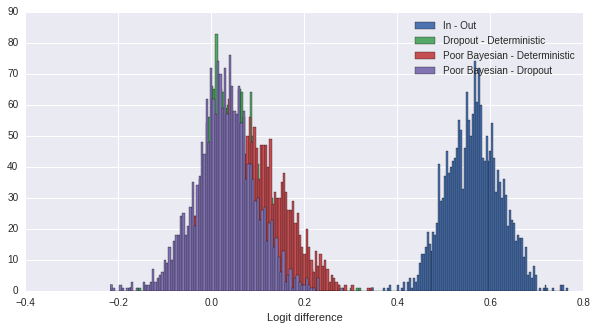

In - Out 95 CI: 0.453969251873 0.675777340641 Pr > 0: 1.0
Dropout - Deterministic 95 CI: -0.0561033019705 0.195938889797 Pr > 0: 0.815
Poor Bayesian - Deterministic 95 CI: -0.0359354537358 0.235524319493 Pr > 0: 0.895
Poor Bayesian - Dropout 95 CI: -0.100478949553 0.156712825319 Pr > 0: 0.687


In [210]:
data = {'K': K, 'N': N, 'y_in': y_in, 'y_out': y_out}
fit = model_two_way.sampling(data=data, iter=1000, chains=4)

print(fit)
fit.plot()
trace = fit.extract()

deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]

plt.figure()
plt.hist(trace['mu_in'], bins = 100, label = 'Base In')
plt.hist(trace['mu_out'], bins = 100, label = 'Base Out')
plt.hist(deterministic, bins = 100, label = 'Deterministic effect')
plt.hist(dropout, bins = 100, label = 'Dropout effect')
plt.hist(poor_bayesian, bins = 100, label = 'Poor Bayesian effect')
plt.legend()
plt.xlabel("Logit")
plt.show()

plt.figure()
plt.hist(trace['mu_in']-trace['mu_out'], bins = 100, label = 'In - Out')

plt.hist(dropout-deterministic, bins = 100, label = 'Dropout - Deterministic')
plt.hist(poor_bayesian-deterministic, bins = 100,label = 'Poor Bayesian - Deterministic')
plt.hist(poor_bayesian-dropout, bins = 100, label = 'Poor Bayesian - Dropout')
plt.legend()
plt.xlabel("Logit difference")
plt.show()

print('In - Out', '95 CI:', np.percentile(trace['mu_in']-trace['mu_out'], 2.5), np.percentile(trace['mu_in']-trace['mu_out'], 97.5), 'Pr > 0:', (trace['mu_in']-trace['mu_out'] > 0).mean())
print('Dropout - Deterministic', '95 CI:', np.percentile(dropout-deterministic, 2.5), np.percentile(dropout-deterministic, 97.5), 'Pr > 0:', (dropout-deterministic > 0).mean())
print('Poor Bayesian - Deterministic', '95 CI:', np.percentile(poor_bayesian-deterministic, 2.5), np.percentile(poor_bayesian-deterministic, 97.5), 'Pr > 0:', (poor_bayesian-deterministic > 0).mean())
print('Poor Bayesian - Dropout', '95 CI:', np.percentile(poor_bayesian-dropout, 2.5), np.percentile(poor_bayesian-dropout, 97.5), 'Pr > 0:', (poor_bayesian-dropout > 0).mean())